In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
FOLDER_PATH = "/Users/admin/codes/jupyter_codes/data/"
#FOLDER_PATH = "data/"

In [59]:
file_path = FOLDER_PATH+"lending_club_2020_train.csv"
origin_data = pd.read_csv(file_path)
origin_data.head()

/var/folders/4k/lxd3n8m934z_82zsdzv73d5r0000gn/T/ipykernel_31036/2516111998.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  origin_data = pd.read_csv(file_path)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82,E,E4,Production Foreman,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
3,126296074,4500.0,4500.0,4500.0,36 months,9.93%,145.06,B,B2,Office Manager,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,148913312,15000.0,15000.0,15000.0,36 months,16.40%,530.33,C,C4,Secretary,...,May-2020,Jul-2020,May-2020,2.0,0.0,ACTIVE,413.83,11025.25,54.62,N


In [60]:
loan_statuses = origin_data['loan_status'].values
print(loan_statuses)
'''
for status in loan_statuses:
    print("====={status}")
    print(len(origin_data[(origin_data['hardship_flag']=='Y')&(origin_data['loan_status']==status)]))
    print(len(origin_data[(origin_data['hardship_flag']=='Y') & (origin_data['loan_status']==status)])*100/len(origin_data[origin_data['hardship_flag']=='Y']))
'''

['Fully Paid' 'Current' 'Charged Off' ... 'Fully Paid' 'Fully Paid'
 'Current']


'\nfor status in loan_statuses:\n    print("====={status}")\n    print(len(origin_data[(origin_data[\'hardship_flag\']==\'Y\')&(origin_data[\'loan_status\']==status)]))\n    print(len(origin_data[(origin_data[\'hardship_flag\']==\'Y\') & (origin_data[\'loan_status\']==status)])*100/len(origin_data[origin_data[\'hardship_flag\']==\'Y\']))\n'

In [61]:
# drop할 컬럼들을 일단 처리한다.
with open('data/'+'drop_columns.txt', mode='r') as f:
    drop_fields = f.readlines()
    drop_fields = [drop_field.strip('\n') for drop_field in drop_fields]

In [62]:
drop_df = origin_data.drop(columns=drop_fields)

In [63]:
len(drop_df.columns)

79

In [64]:
drop_df['loan_status'].value_counts()

loan_status
Fully Paid                                             898522
Current                                                618688
Charged Off                                            217366
Late (31-120 days)                                       9840
In Grace Period                                          6049
Late (16-30 days)                                        1620
Issued                                                   1258
Does not meet the credit policy. Status:Fully Paid       1223
Does not meet the credit policy. Status:Charged Off       460
Default                                                   268
Name: count, dtype: int64

In [65]:
modified_df = drop_df[~drop_df['loan_status'].isin(['Current', 'Issued', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'])]

In [66]:
modified_df.loc[modified_df['loan_status'].isin(['Fully Paid', 'In Grace Period']), 'loan_status'] = 0
modified_df.loc[modified_df['loan_status'].isin(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_status'] = 1

In [67]:
len(modified_df)

1133666

In [68]:
len(modified_df.duplicated())

1133666

In [69]:
modified_df = modified_df.dropna(subset=modified_df.columns.difference(['loan_status']),how='all')

In [70]:
# term : 36 months -> 36 으로 변환해줘야한다.
# modified_df['term'] = modified_df['term'].astype(str).apply(delete_suffix)

# 이 함수는 쓸 일 없어짐(int_rate 필드 drop함)
# modified_df['int_rate'] = modified_df['int_rate'].astype(str).apply(delete_suffix_percentage)

# modified_df['revol_util'] = modified_df['revol_util'].astype(str).apply(delete_suffix_percentage)

# zip_code : 554xx -> 554로 변환해줘야한다.
# modified_df['zip_code'] = modified_df['zip_code'].astype(str).apply(delete_suffix_xx)


# columns_to_modify = ['earliest_cr_line','last_pymnt_d','next_pymnt_d',
#                      'last_credit_pull_d','sec_app_earliest_cr_line',
#                      'hardship_start_date','hardship_end_date',
#                      'payment_plan_start_date', 'issue_d']
# apply_to_multiple_columns(columns_to_modify)

def delete_suffix(term:str)->int:
    '''첫 단어만을 저장하는 함수'''
    term = term.strip().split()[0]
    return int(term)

def delete_suffix_percentage(term:str)->float:
    '''%를 자르는 함수'''
    term = term.strip('%')
    return float(term)

def delete_suffix_xx(term:str)->int:
    '''xx를 자르는 함수'''
    term = term.strip('xx')
    return int(term)

def apply_to_multiple_columns(date_columns:list)->None:
    '''modified_df에서 %b-%Y(Aug-2006) 형식의 날짜 정보를 %Y-%m-%d(2006-08-01)형태로 저장하는 함수'''
    for col in date_columns:
        modified_df[col]=pd.to_datetime(modified_df[col], format='%b-%Y')

def process_emp_length(term:str)->int:
    if term =='< 1 year':
        return 0
    elif term=='10+ years':
        return 10
    term = term.strip()

In [71]:
modified_df['term'] = modified_df['term'].astype(str).apply(delete_suffix)

In [72]:
modified_df.select_dtypes('object').columns

Index(['sub_grade', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state', 'revol_util',
       'application_type', 'verification_status_joint'],
      dtype='object')

In [73]:
THRESHOLD = 50

null_percentages = (modified_df.isnull().sum() * 100) / len(modified_df)
columns_to_drop = null_percentages[null_percentages >= THRESHOLD].index
columns_to_keep = null_percentages[null_percentages < THRESHOLD].index
# 필드 추출
filtered_df = modified_df[columns_to_keep]
filtered_df.columns
columns_to_drop

Index(['mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq'],
      dtype='object')

In [74]:
result_df = filtered_df[(filtered_df['pub_rec_bankruptcies'] != 0)]
print(filtered_df['pub_rec_bankruptcies'].isna().sum())
filtered_df['pub_rec_bankruptcies'].value_counts()

439


pub_rec_bankruptcies
0.0     992516
1.0     133256
2.0       5796
3.0       1186
4.0        305
5.0        109
6.0         34
7.0         14
8.0          6
9.0          2
11.0         1
12.0         1
Name: count, dtype: int64

In [75]:
filtered_df.shape

(1133665, 71)

In [76]:
filtered_df.select_dtypes('object').columns

Index(['sub_grade', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state', 'revol_util',
       'application_type'],
      dtype='object')

<Axes: xlabel='revol_bal'>

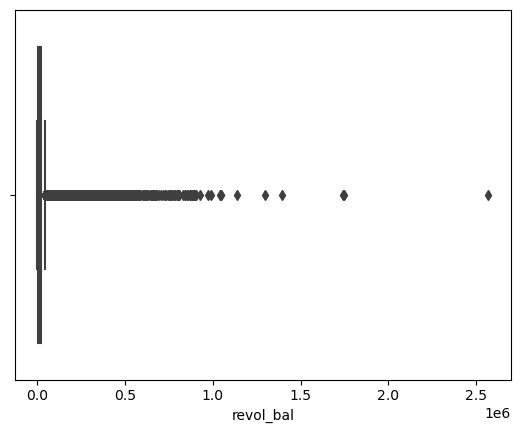

In [77]:
sns.boxplot(data=filtered_df, x='revol_bal')

In [78]:
filtered_df.shape

(1133665, 71)

In [79]:
def check_field(column_name:str)->None:
    print("==============isnull")
    print(filtered_df[column_name].isnull().sum()*100/len(filtered_df[column_name]), '%')
    print("==============isna")
    print(filtered_df[column_name].isna().sum()*100/len(filtered_df[column_name]), '%')
    print("==============head")
    print(filtered_df[column_name].head())
    print("==============value_count")
    print(filtered_df[column_name].value_counts())

In [80]:
filtered_df['emp_length'].isna().sum()

72190

In [81]:
check_field("total_cu_tl")

==============isnull
44.833526659110056 %
==============isna
44.833526659110056 %
==============head
0    0.0
2    3.0
5    0.0
6    0.0
7    NaN
Name: total_cu_tl, dtype: float64
==============value_count
total_cu_tl
0.0     330621
1.0     105028
2.0      59299
3.0      37934
4.0      25532
5.0      17691
6.0      13098
7.0       9203
8.0       6821
9.0       4982
10.0      3649
11.0      2689
12.0      2002
13.0      1585
14.0      1203
15.0       946
16.0       686
17.0       514
18.0       390
19.0       302
20.0       229
21.0       181
22.0       148
23.0       127
24.0       109
25.0        79
26.0        71
27.0        43
28.0        39
30.0        32
29.0        24
32.0        20
31.0        18
33.0        16
34.0        14
35.0        12
37.0         9
40.0         8
36.0         7
38.0         5
41.0         4
54.0         4
49.0         4
44.0         3
45.0         3
39.0         3
42.0         3
48.0         2
56.0         2
43.0         2
68.0         2
60.0         1
71

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12.]
0.0
80.21563380338453
1.0
76.90685597646635
2.0
74.44789510006902
3.0
77.48735244519393
4.0
70.49180327868852
5.0
74.31192660550458
6.0
76.47058823529412
7.0
71.42857142857143
8.0
83.33333333333333
9.0
50.0
11.0
0.0
12.0
100.0
na
82.46013667425969


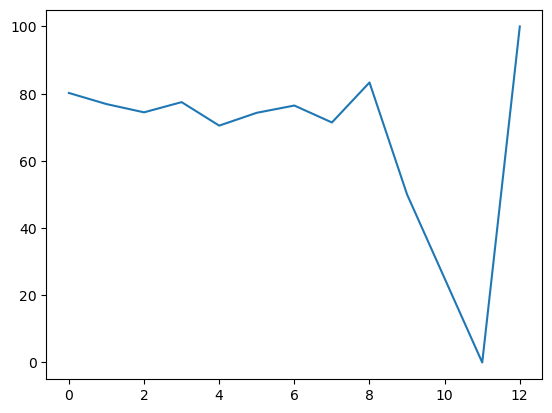

In [82]:
target_column = "pub_rec_bankruptcies"
column_values =filtered_df[target_column].unique()
column_values = column_values[~pd.isna(column_values)]
column_values.sort()
print(column_values)
x = []
y =[]
for value in column_values:
    pos_percent = len(filtered_df[(filtered_df[target_column]==value) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column]==value])
    print(value)
    print(pos_percent)
    x.append(value)
    y.append(pos_percent)

print("na")
print(len(filtered_df[(filtered_df[target_column].isna()) & (filtered_df['loan_status']==0)])*100/len(filtered_df[filtered_df[target_column].isna()]))
plt.plot(x, y)

====before column_values
num_rev_tl_bal_gt_0
0.0       5699
1.0      42327
2.0     107389
3.0     155643
4.0     168781
5.0     153728
6.0     125211
7.0      96024
8.0      70500
9.0      50694
10.0     35430
11.0     24406
12.0     17214
13.0     11808
14.0      8249
15.0      5852
16.0      4218
17.0      2930
18.0      2016
19.0      1442
20.0      1015
21.0       718
22.0       516
23.0       368
24.0       278
25.0       235
26.0       141
27.0       119
28.0        79
29.0        67
30.0        41
31.0        35
32.0        21
33.0        10
34.0        14
35.0        11
36.0         9
37.0         3
38.0         6
39.0         2
40.0         1
41.0         2
42.0         1
43.0         2
44.0         1
45.0         1
55.0         1
58.0         1
59.0         1
65.0         1
Name: count, dtype: int64
====before column_values_safe
num_rev_tl_bal_gt_0
0.0       4529
1.0      34906
2.0      88582
3.0     127809
4.0     136740
5.0     122971
6.0      99027
7.0      75156
8.0      

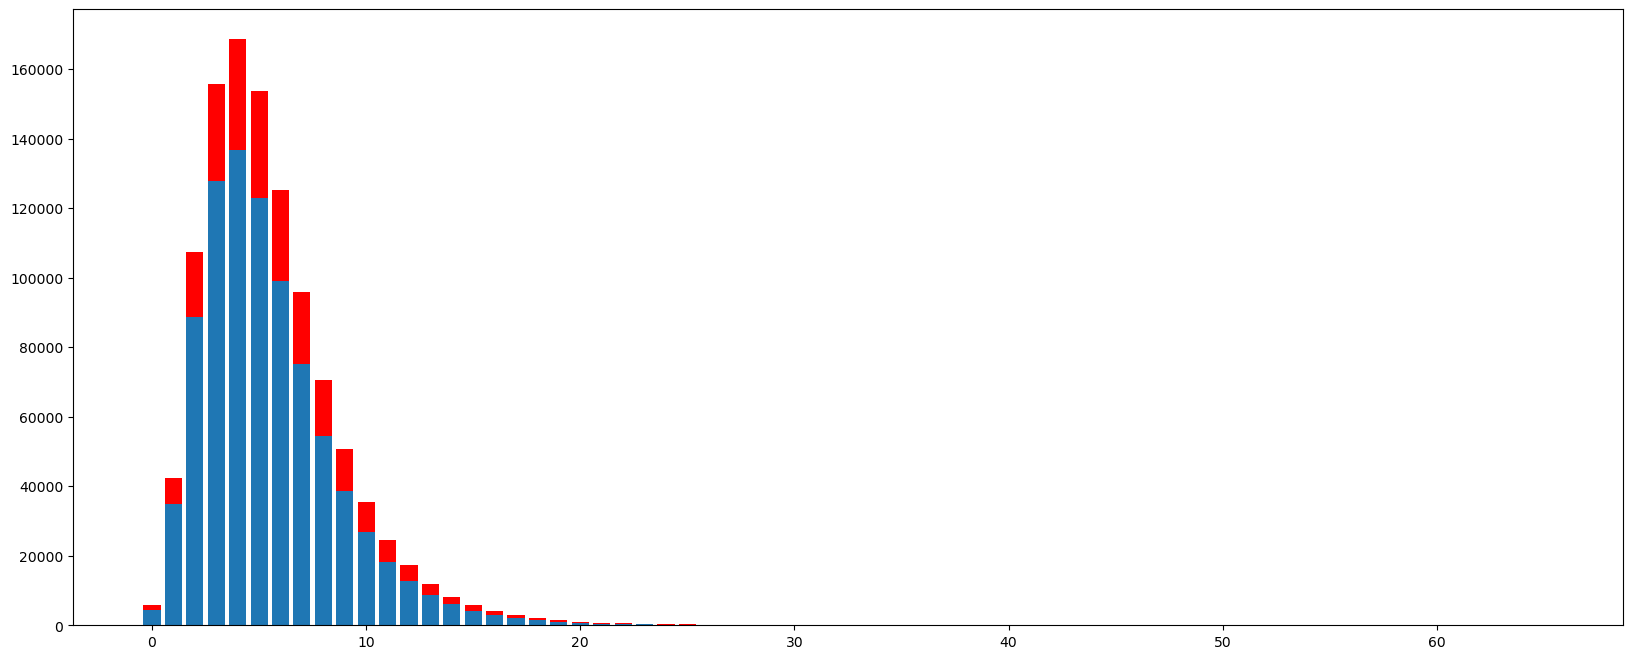

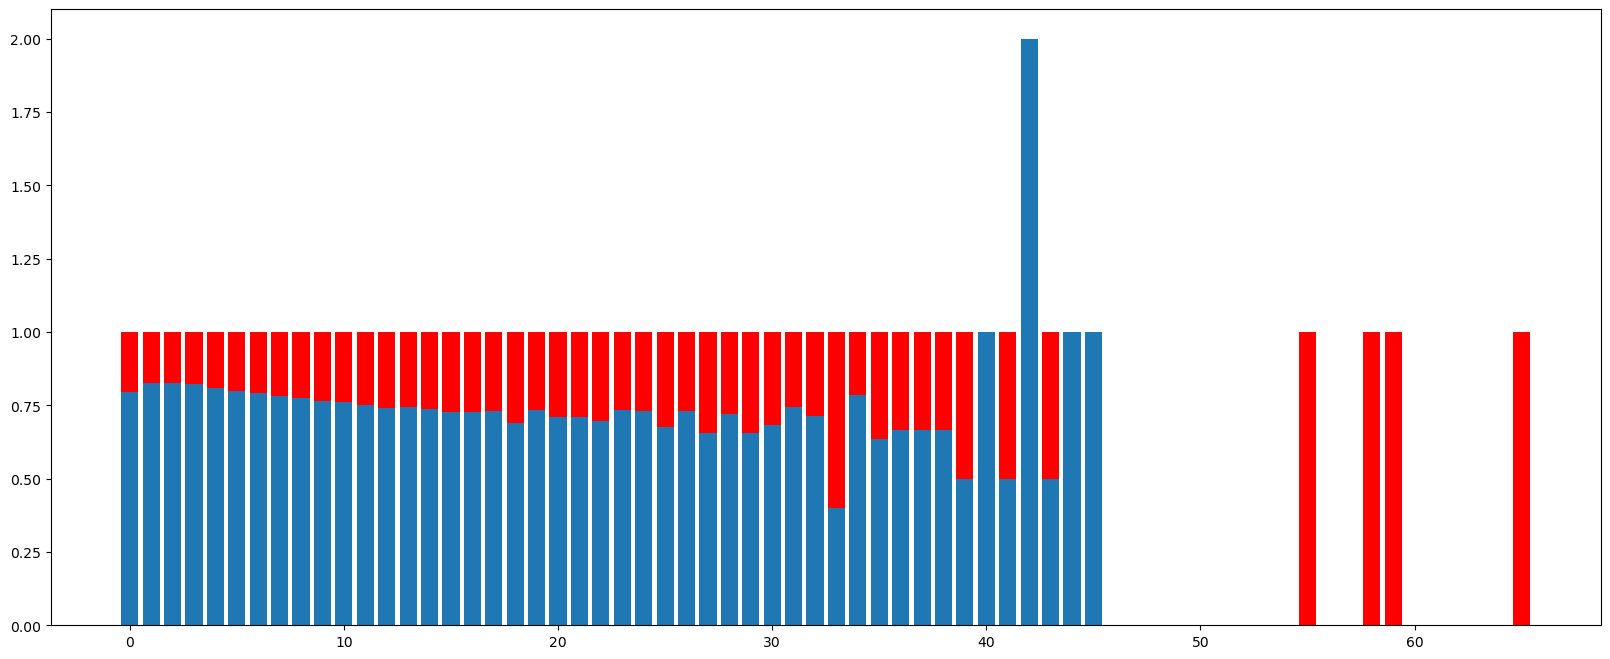

In [104]:
import matplotlib.pyplot as plt

def plot_col(filtered_df, target_column):
  """
    target_column의 값 별 도수를 시각화하는 함수
    target_column은 수치형 변수 (우선 정수형 변수만..)

    arguments:
      filtered_df : 데이터프레임
      target_column : filtered_df에서 시각화할 변수
      loan_status : 반응변수 종류. 값 = {0,1}
    result:
      barplot 시각화
  """
  column_values = filtered_df[target_column].value_counts().sort_index()
  num_notna = column_values.sum()

  plt.figure(figsize=(20,8))
  print("====before column_values")
  print(column_values)
  column_values_safe = filtered_df[filtered_df['loan_status']==0][target_column].value_counts().sort_index()
  print("====before column_values_safe")
  print(column_values_safe)
  
  for value in column_values_safe.index:
    if value not in column_values:
      column_values[value] = 0

  # b_value_counts에 없는 값에 대해 a_value_counts에 0으로 추가
  for value in column_values.index:
    if value not in column_values_safe:
      column_values_safe[value] = 0
  print("-======after column_values")
  print(column_values)
  print("-======after column_values_safe")
  print(column_values_safe)
  pos_percent = [val / total for val, total in zip(column_values_safe, column_values)]

  plt.bar(column_values.index, column_values, color='r')
  plt.bar(column_values.index, column_values_safe)
  plt.show()
  plt.figure(figsize=(20,8))
  plt.bar(column_values.index, [1]*len(column_values), color='r')
  plt.bar(column_values.index, pos_percent)
  plt.show()

plot_col(filtered_df, 'num_rev_tl_bal_gt_0')

In [84]:
filtered_df.shape

(1133665, 71)

In [85]:
check_field("purpose")

==============isnull
0.0 %
==============isna
0.0 %
==============head
0    debt_consolidation
2    debt_consolidation
5      home_improvement
6      home_improvement
7           credit_card
Name: purpose, dtype: object
==============value_count
purpose
debt_consolidation    648300
credit_card           251730
home_improvement       75174
other                  69046
major_purchase         25495
medical                13778
small_business         12550
car                    12240
vacation                8140
moving                  7965
house                   6922
wedding                 1339
renewable_energy         806
educational              180
Name: count, dtype: int64


In [86]:
'''
emp length, 
desc, 
earliest cr line, 
fico range low, 
fico range high
'''

'\nemp length, \ndesc, \nearliest cr line, \nfico range low, \nfico range high\n'

In [87]:
pub_rec_bankruptcies_df = filtered_df[filtered_df['total_cu_tl'].isna()]
len(pub_rec_bankruptcies_df[pub_rec_bankruptcies_df['loan_status']==1])*100/len(pub_rec_bankruptcies_df)

18.04207278923075

36 83.73268998337672 16.267310016623284
60 68.17991937673622 31.820080623263777


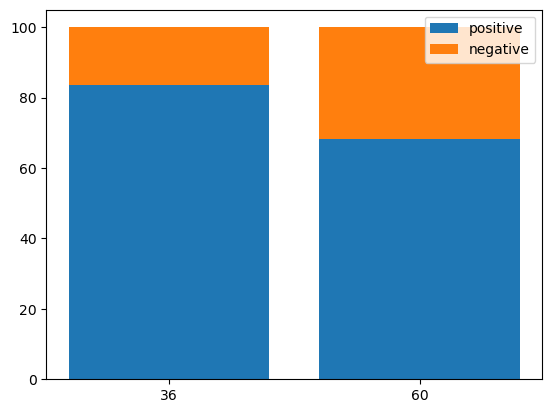

In [88]:
def print_term():
    x = np.arange(2)
    months = [36, 60]
    pos = []
    neg = []
    filtered_df.head()
    for data in months:
        month_df = filtered_df[filtered_df['term']==data]
        positive_percent = len(month_df[month_df['loan_status']==0])*100/len(month_df)
        negative_percent = 100-positive_percent
        pos.append(positive_percent)
        neg.append(negative_percent)
        print(data, positive_percent, negative_percent)
    plt.bar(x, pos, label='positive')
    plt.xticks(x, months)
    plt.bar(x, neg, label='negative', bottom=pos)
    plt.legend()
    plt.show()
print_term()

A1 95.97331955007508
A2 94.6468534598514
A3 93.16347341510355
A4 91.79787074523917
A5 90.5840395610052
B1 88.84742750989419
B2 87.61316141941938
B3 86.25108406351865
B4 84.31609130138541
B5 82.53067203808826
C1 80.3563050258052
C2 78.47216983267197
C3 76.74672661927455
C4 74.57951375049821
C5 72.96689333058589
D1 72.16959962206212
D2 69.71351993729297
D3 68.50226203673188
D4 67.40630823383256
D5 65.51682106289614
E1 64.89241860989073
E2 64.09799554565701
E3 61.78896779284126
E4 59.954252795662484
E5 57.75907417148869
F1 58.68779538504309
F2 55.132778438367026
F3 55.74780753733112
F4 52.37952708769829
F5 52.85103349964362
G1 50.956602893140456
G2 52.305574673090156
G3 49.7789566755084
G4 48.86486486486486
G5 43.65361803084223


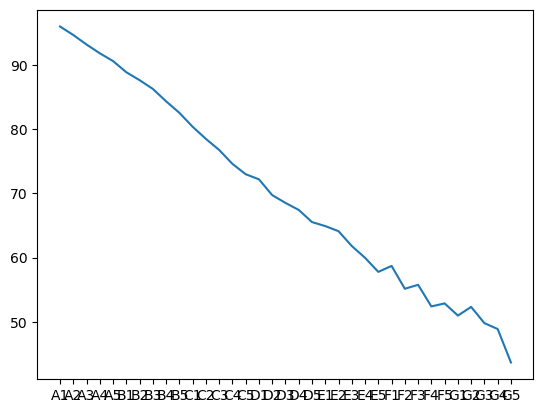

In [89]:
def print_sub_grade():
    x = []
    y = []
    for c in ['A', 'B', 'C','D','E','F','G']:
        for i in range(1, 6):
            sub_grade = c+str(i)
            sub_grade_df = filtered_df[filtered_df["sub_grade"]==sub_grade]
            positive_percent = len(sub_grade_df[sub_grade_df['loan_status']==0])*100/len(sub_grade_df)
            x.append(sub_grade)
            y.append(positive_percent)
            print(sub_grade, positive_percent)
    plt.plot(x,y)    
print_sub_grade()

In [90]:
filtered_df.to_csv("data/filtered_lending_club_data.csv")

In [91]:
filtered_df[filtered_df['issue_d'].isna()]

,loan_amnt,term,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit


In [92]:
# FOLDER_PATH = "/content/drive/MyDrive/2402빅데이터/" ## 파일 경로
file_path = "data/filtered_lending_club_data.csv"
origin_data = pd.read_csv(file_path)

for var in origin_data.columns:
  print(var, '\t\t\t\t', origin_data[var].isna().sum())

Unnamed: 0 				 0
loan_amnt 				 0
term 				 0
sub_grade 				 0
emp_length 				 72190
home_ownership 				 0
annual_inc 				 0
verification_status 				 0
issue_d 				 0
loan_status 				 0
purpose 				 0
addr_state 				 0
dti 				 679
delinq_2yrs 				 0
fico_range_low 				 0
fico_range_high 				 0
inq_last_6mths 				 0
open_acc 				 0
pub_rec 				 0
revol_bal 				 0
revol_util 				 866
total_acc 				 0
collections_12_mths_ex_med 				 38
application_type 				 0
acc_now_delinq 				 0
tot_cur_bal 				 40404
open_acc_6m 				 508262
open_act_il 				 508262
open_il_12m 				 508262
open_il_24m 				 508262
mths_since_rcnt_il 				 526428
total_bal_il 				 508262
open_rv_12m 				 508262
open_rv_24m 				 508262
max_bal_bc 				 508262
all_util 				 508352
total_rev_hi_lim 				 40404
total_cu_tl 				 508262
acc_open_past_24mths 				 28301
avg_cur_bal 				 40441
bc_open_to_buy 				 40758
bc_util 				 41347
chargeoff_within_12_mths 				 38
delinq_amnt 				 0
mo_sin_old_il_acct 				 73214
mo_sin_old_rev

In [93]:
def modify_date(dataframe:pd.DataFrame, col:str)->None:
    '''modified_df에서 %b-%Y(Aug-2006) 형식의 날짜 정보를 %Y-%m-%d(2006-08-01)형태로 저장하는 함수'''
    dataframe[col]=pd.to_datetime(dataframe[col], format='%b-%Y')
    dataframe[col+'_month'] = pd.to_datetime(dataframe[col], format='%b-%Y').dt.month
    dataframe[col+'_year'] = pd.to_datetime(dataframe[col], format='%b-%Y').dt.year

In [94]:
modify_date(origin_data, 'issue_d')

In [95]:
def printing_null(column_name:str)->None:
    f_df = origin_data[origin_data[column_name].isna()]
    rtn = f_df['issue_d_year'].value_counts()
    print('===============',column_name)
    print(rtn)
    print(sum(rtn))
    rtn.plot.bar()
    

In [96]:
def printing_not_null(column_name:str)->None:
    f_df = origin_data[~origin_data[column_name].isna()]
    rtn = f_df['issue_d_year'].value_counts()
    print(rtn)
    print(sum(rtn))
    rtn.plot.bar()
    

In [97]:
origin_data['open_acc_6m'].isna().sum()

508262

issue_d_year
2016    236200
2015    235383
2017    185932
2014    136654
2018    119469
2013     78137
2019     50711
2012     14697
2020      3268
Name: count, dtype: int64
1060451


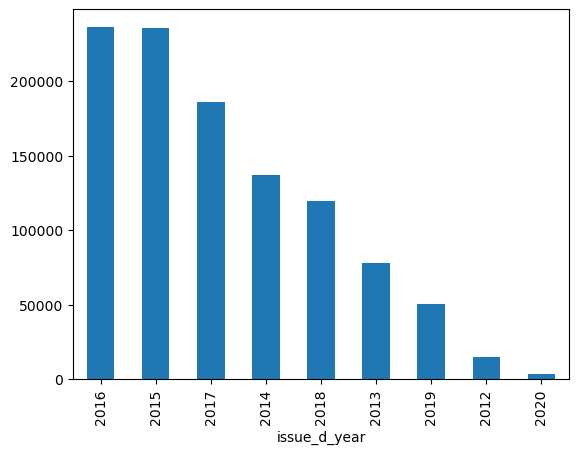

In [98]:
printing_not_null('mo_sin_old_il_acct')

=============== tot_cur_bal
issue_d_year
2012    16652
2011    12985
2010     6856
2009     2815
2008      941
2007      155
Name: count, dtype: int64
40404


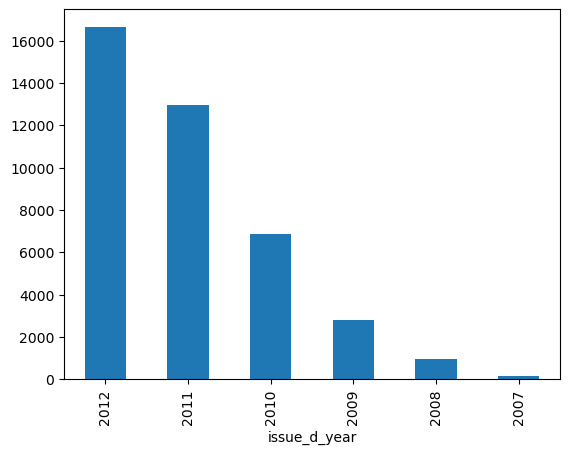

In [99]:
printing_null('tot_cur_bal')

In [100]:
columns = origin_data.columns
for column_name in columns:
    print(column_name)
    print(column_name,'\t\t',(origin_data[column_name].isnull().sum()*100/len(origin_data[column_name])),'%')


Unnamed: 0
Unnamed: 0 		 0.0 %
loan_amnt
loan_amnt 		 0.0 %
term
term 		 0.0 %
sub_grade
sub_grade 		 0.0 %
emp_length
emp_length 		 6.367842352017571 %
home_ownership
home_ownership 		 0.0 %
annual_inc
annual_inc 		 0.0 %
verification_status
verification_status 		 0.0 %
issue_d
issue_d 		 0.0 %
loan_status
loan_status 		 0.0 %
purpose
purpose 		 0.0 %
addr_state
addr_state 		 0.0 %
dti
dti 		 0.059894236833632514 %
delinq_2yrs
delinq_2yrs 		 0.0 %
fico_range_low
fico_range_low 		 0.0 %
fico_range_high
fico_range_high 		 0.0 %
inq_last_6mths
inq_last_6mths 		 0.0 %
open_acc
open_acc 		 0.0 %
pub_rec
pub_rec 		 0.0 %
revol_bal
revol_bal 		 0.0 %
revol_util
revol_util 		 0.07638940956984647 %
total_acc
total_acc 		 0.0 %
collections_12_mths_ex_med
collections_12_mths_ex_med 		 0.0033519602351664733 %
application_type
application_type 		 0.0 %
acc_now_delinq
acc_now_delinq 		 0.0 %
tot_cur_bal
tot_cur_bal 		 3.564015824780689 %
open_acc_6m
open_acc_6m 		 44.833526659110056 %
open_act_il
o

In [101]:
# drop할 컬럼들을 일단 처리한다.
with open('columns.txt', mode='r') as f:
    search_fields = f.readlines()
    search_fields = [search_field.strip('\n') for search_field in search_fields]
    search_fields = [search_field.strip('\t') for search_field in search_fields]
    search_fields = [search_field.strip() for search_field in search_fields]

In [102]:
printing_null("mths_since_last_delinq")

KeyError: 'mths_since_last_delinq'

In [ ]:
origin_data['bc_open_to_buy'].value_counts()

bc_open_to_buy
0.0         16460
500.0         995
2000.0        960
1000.0        878
3000.0        827
            ...  
81989.0         1
49058.0         1
115045.0        1
51711.0         1
96107.0         1
Name: count, Length: 74710, dtype: int64